In [4]:
import numpy as np 
from numpy import argmax
from numpy import array_equal
from numpy import array
import statistics

import tensorflow as tf
import itertools
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

from keras.metrics import categorical_crossentropy

from itertools import chain

tf.keras.backend.set_floatx('float64')


In [5]:
#Checking for tensorflow-GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


In [6]:
#Unzipping Attack and Validation folders

# Unzip Attack Folder to retrive subfolfers
from zipfile import ZipFile
file_name = "Attack_Data_Master.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Unizipped Attack File')
    
# Unzip Validation Folder to retrive subfolfers
from zipfile import ZipFile
file_name = "Validation_Data_Master.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Unizipped Validation File')
    
# Unzip Training Folder to retrive subfolfers
from zipfile import ZipFile
file_name = "Training_Data_Master.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Unizipped Training File')

# list holding normal training data
train_normal_data = [] 



from pathlib import Path 
# list that holds attack vectors
train_attack_data = []

# Set file path ot the folder for iterations
input_dir = Path.cwd() / "Attack_Data_Master"
# store all the files ending with .txt in a list called files
files = list (input_dir.rglob("*.txt*"))
# Iterate over all the txt files and append the attack in the list train_attack data
for FILE in files:
  with open (FILE, 'r') as f:
    stringData = (f.read())
    string_split_data = stringData.split(" ")
    del (string_split_data[-1])
    train_attack_data.append(string_split_data)
    

for i in range(len(train_attack_data)):
  for j in range(len(train_attack_data[i])):
    train_attack_data[i][j] = int(train_attack_data[i][j])

from pathlib import Path 
# list that holds validation vectors
train_validation_data = []

# Set file path ot the folder for iterations
input_dir = Path.cwd() / "Validation_Data_Master"
# store all the files ending with .txt in a list called files
files = list (input_dir.rglob("*.txt*"))
# Iterate over all the txt files and append the attack in the list train_attack data
for FILE in files:
  with open (FILE, 'r') as f:
    stringData = (f.read())
    string_split_data = stringData.split(" ")
    del (string_split_data[-1])
    train_validation_data.append(string_split_data)
    

# list that holds training vectors
train_normal_data = []

# Set file path ot the folder for iterations
input_dir = Path.cwd() / "Training_Data_Master"
# store all the files ending with .txt in a list called files
files = list (input_dir.rglob("*.txt*"))
# Iterate over all the txt files and append the attack in the list train_attack data
for FILE in files:
  with open (FILE, 'r') as f:
    stringData = (f.read())
    string_split_data = stringData.split(" ")
    del (string_split_data[-1])
    train_normal_data.append(string_split_data)
    

for i in range(len(train_normal_data)):
  for j in range(len(train_normal_data[i])):
    train_normal_data[i][j] = int(train_normal_data[i][j])
print("Normal Data     --->  train_normal_data")
print("Attack Data     --->  train_attack_data")
print("Validation Data --->  train_validation_data")


Unizipped Attack File
Unizipped Validation File
Unizipped Training File
Normal Data     --->  train_normal_data
Attack Data     --->  train_attack_data
Validation Data --->  train_validation_data


In [7]:
#Statistics of the data

#Shortest request
shortest_seq = 1000;
#Longest request
longest_seq = 0;
#Average Request size in dataset
avg_seq = 0

sum = 0;
for i in range(len(train_normal_data)):
    curr_sequence_length = len(train_normal_data[i])
    if curr_sequence_length < shortest_seq:
        shortest_seq = curr_sequence_length
    if curr_sequence_length > longest_seq:
        longest_seq = curr_sequence_length
    sum += curr_sequence_length
avg_seq = int(sum/len(train_normal_data))

print(f"Shortest Request Length is {shortest_seq}")
print(f"Longest Request Length is {longest_seq}")
print(f"Average Request Length is {avg_seq}")
    

Shortest Request Length is 79
Longest Request Length is 2948
Average Request Length is 369


In [8]:
len(train_validation_data)

4372

In [9]:
#Number of unique system calls in the normal list
unique_normal = []
# System calls that are present in the attack list but not in normal
attack_not_in_normal = []

#Appending unique system calls from the normal list
for i in range(len(train_normal_data)):
    for j in range(len(train_normal_data[i])):
        curr_sys_call = train_normal_data[i][j]
        if curr_sys_call in unique_normal:
            continue
        else:
            unique_normal.append(curr_sys_call)

#Appending unique system calls from the attack list that are not present in normal
for i in range(len(train_attack_data)):
    for j in range(len(train_attack_data[i])):
        curr_sys_call = train_attack_data[i][j]
        if curr_sys_call not in unique_normal:
            attack_not_in_normal.append(curr_sys_call)

In [10]:
# Unique system calls in normal list
len(unique_normal)

150

In [11]:
# Unique system calls in attack list not present in normal
attack_not_in_normal

[324, 324, 324, 324, 324, 324, 324, 173, 156]

In [12]:
freq_normal_dict = {}
#Appending unique system calls from the normal list
for i in range(len(train_normal_data)):
    for j in range(len(train_normal_data[i])):
        curr_sys_call = train_normal_data[i][j]
        if curr_sys_call in freq_normal_dict:
            freq_normal_dict[curr_sys_call] += 1 
        else:
            freq_normal_dict[curr_sys_call] = 0


In [13]:
 for i in sorted (freq_normal_dict.keys()):
     print(f"{i}:{freq_normal_dict[i]}", end = " ")

1:538 3:55663 4:31341 5:20502 6:22781 7:1554 8:1 9:40 10:246 11:700 12:70 13:893 15:22 19:832 20:79 21:3 26:3 27:189 30:15 33:7257 37:17 38:223 39:47 40:68 41:92 42:1226 43:1 45:5941 54:2768 57:40 60:104 63:941 64:72 65:9 66:44 75:0 77:1 78:10007 83:6 85:402 91:5599 93:19 94:32 96:11 97:29 99:6 102:8645 104:2 110:0 114:792 117:14 118:283 119:184 120:2214 122:298 125:4824 128:1 132:2 133:16 140:3759 141:268 142:1427 143:36 144:6 146:1602 148:32 155:39 157:30 158:97 159:88 160:82 162:259 163:24 168:10751 172:34 174:5911 175:5841 176:117 179:2 180:5960 183:22 184:1 185:0 191:198 192:13096 194:29 195:19413 196:3740 197:9975 198:0 199:344 200:111 201:377 202:123 203:8 204:8 205:6 206:5 207:29 208:11 209:20 211:15 212:8 213:19 214:6 219:281 220:1272 221:9783 224:0 226:9 228:8 229:15 230:7 231:8 233:0 234:1 240:13708 242:66 243:353 252:391 254:13 255:132 256:96 258:157 259:0 260:0 264:0 265:8222 266:44 268:123 269:11 270:2 272:4 289:6 292:43 293:8 295:8 298:3 300:35 301:194 307:46 308:314 309

In [14]:
freq_attack_dict = {}
#Appending unique system calls from the normal list
for i in range(len(train_attack_data)):
    for j in range(len(train_attack_data[i])):
        curr_sys_call = train_attack_data[i][j]
        if curr_sys_call in freq_attack_dict:
            freq_attack_dict[curr_sys_call] += 1 
        else:
            freq_attack_dict[curr_sys_call] = 0

In [15]:
 for i in sorted (freq_attack_dict.keys()) :
     print(f"{i}:{freq_attack_dict[i]}", end = " ")

3:45818 4:5551 5:6445 6:4190 7:293 10:224 11:66 12:48 13:6750 19:1693 20:1 27:749 33:1451 37:2 38:1 39:15 40:5 41:17 42:3 43:6070 45:346 54:4724 57:46 60:57 63:62 64:0 65:4 66:17 78:21124 85:723 91:2368 102:7780 104:2581 114:2045 117:5 118:4 119:518 120:160 122:111 125:1696 132:0 140:1132 141:67 142:11781 146:5505 156:0 158:111 160:0 162:6991 163:124 168:75174 172:9 173:0 174:1951 175:2694 183:25 191:61 192:3578 194:0 195:3321 196:794 197:1970 199:253 200:1 201:87 202:1 205:0 206:26 219:156 220:161 221:629 224:2 240:11315 242:15 243:54 256:573 258:67 265:61395 266:2 268:102 292:102 295:17 300:32 301:755 307:12 309:1973 311:70 324:6 331:12 340:429 

In [16]:
#Generating one hot vectors
dict = {}
vocab_size = 341

for x in range(vocab_size):
    arr=[]
    arr = [0 for i in range(vocab_size)] 
    arr[x] = 1
    dict[x] = arr

In [17]:
#Sequence size
n = 15
#N-Gram
m = 5

In [18]:
# This method receives a request array and returns one hot encoded version of that array
def generate_one_hot(request):
    temp = []
    for sys_call in request:
        temp.append(dict[int(sys_call)])
    return temp

# This method recevies a request array, start and  end of the request and populates x_train and y_train
# with returned one hot version from the generate_trainSet method
def split_request(source, target, request, start, end):
    while(len(request)-start >= n+m):
        source.append(generate_one_hot(request[start:end]))
        start += m
        end += m
        target.append(generate_one_hot(request[start:end]))
    

In [19]:
x_train = []
y_train = [] 

# Populating x_train and y_train with sources and targets
for i in range(len(train_normal_data)):
    split_request(x_train, y_train, train_normal_data[i],0,n)

In [20]:
print(len(x_train))
print(len(y_train))
print(len(train_normal_data))


58791
58791
833


In [21]:
x_train = x_train[:58000]
y_train = y_train[:58000]

In [22]:
#Converting x_train and y_train into np arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

In [23]:
#x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)

(58000, 15, 341)


In [24]:
# split test data into training and testing sets
x_train, x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.20,random_state=4)

In [25]:
print(x_test.shape)

(11600, 15, 341)


In [26]:
n_timesteps_in= n
n_features = vocab_size
numberOfLSTMunits = 200 

def create_hard_coded_decoder_input_model(batch_size):
  # The first part is encoder
  encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
  encoder_lstm = LSTM(numberOfLSTMunits, return_state=True,  name='encoder_lstm')
  encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
  
  # initial context vector is the states of the encoder
  states = [state_h, state_c]
  
  # Set up the decoder layers
  # Attention: decoder receives 1 token at a time &
  # decoder outputs 1 token at a time 
  decoder_inputs = Input(shape=(1, n_features))
  decoder_lstm = LSTM(numberOfLSTMunits, return_sequences=True, 
                      return_state=True, name='decoder_lstm')
  decoder_dense = Dense(n_features, activation='softmax',  name='decoder_dense')

  all_outputs = []
  # Prepare decoder initial input data: just contains the START character 0
  # Note that we made it a constant one-hot-encoded in the model
  # that is, [1 0 0 0 0 0 0 0 0 0] is the initial input for each loop
  decoder_input_data = np.zeros((batch_size, 1, n_features))
  decoder_input_data[:, 0, 0] = 1 
  
  # that is, [1 0 0 0 0 0 0 0 0 0] is the initial input for each loop
  inputs = decoder_input_data
  # decoder will only process one time step at a time
  # loops for fixed number of time steps: n_timesteps_in
  for _ in range(n_timesteps_in):
      # Run the decoder on one time step
      outputs, state_h, state_c = decoder_lstm(inputs,
                                              initial_state=states)
      outputs = decoder_dense(outputs)
      # Store the current prediction (we will concatenate all predictions later)
      all_outputs.append(outputs)
      # Reinject the outputs as inputs for the next loop iteration
      # as well as update the states
      inputs = outputs
      states = [state_h, state_c]

  # Concatenate all predictions such as [batch_size, timesteps, features]
  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

  # Define and compile model 
  model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [27]:
#@title Function to Train & Test  given model (Early Stopping monitor 'val_loss')
def train_test(model, X_train, y_train , X_test, 	y_test, epochs=500, batch_size=32, patience=5,verbose=0):
	# patient early stopping
	#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
	# train model
	print('training for ',epochs,' epochs begins with EarlyStopping(monitor= val_loss, patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,batch_size=batch_size, verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	#print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, batch_size=batch_size, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()

In [30]:
#@title
batch_size = 40
model_encoder_decoder=create_hard_coded_decoder_input_model(batch_size=batch_size)
model_encoder_decoder.summary()

# due to conflict between tf version:  2.4.1 and tf.keras version: 2.4.0 
# currently plot_model function generates error
# it is a known bug as of 23 May 2021
# therefore I commented the plot_model call below.
#tf.keras.utils.plot_model(model_encoder_decoder, show_shapes=True)

Model: "model_encoder_decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 15, 341)]    0           []                               
                                                                                                  
 encoder_lstm (LSTM)            [(None, 200),        433600      ['encoder_inputs[0][0]']         
                                 (None, 200),                                                     
                                 (None, 200)]                                                     
                                                                                                  
 decoder_lstm (LSTM)            [(40, 1, 200),       433600      ['encoder_lstm[0][1]',           
                                 (None, 200),                     'encoder_lst

                                                                  'decoder_dense[13][0]',         
                                                                  'decoder_dense[14][0]']         
                                                                                                  
Total params: 935,741
Trainable params: 935,741
Non-trainable params: 0
__________________________________________________________________________________________________


training for  500  epochs begins with EarlyStopping(monitor= val_loss, patience= 5 )....
Epoch 1/500
1044/1044 [==============================] - 106s 85ms/step - loss: 1.6571 - accuracy: 0.4953 - val_loss: 1.3746 - val_accuracy: 0.5310
Epoch 2/500
1044/1044 [==============================] - 95s 91ms/step - loss: 1.2321 - accuracy: 0.5782 - val_loss: 1.1335 - val_accuracy: 0.5944
Epoch 3/500
1044/1044 [==============================] - 100s 96ms/step - loss: 1.0147 - accuracy: 0.6497 - val_loss: 0.9383 - val_accuracy: 0.6756
Epoch 4/500
1044/1044 [==============================] - 105s 100ms/step - loss: 0.8820 - accuracy: 0.6957 - val_loss: 0.8361 - val_accuracy: 0.7139
Epoch 5/500
1044/1044 [==============================] - 107s 103ms/step - loss: 0.7903 - accuracy: 0.7292 - val_loss: 0.7911 - val_accuracy: 0.7304
Epoch 6/500
1044/1044 [==============================] - 106s 101ms/step - loss: 0.7178 - accuracy: 0.7572 - val_loss: 0.6992 - val_accuracy: 0.7672
Epoch 7/500
1044/1044

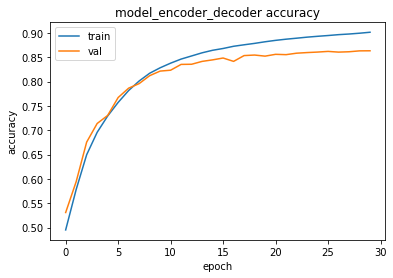

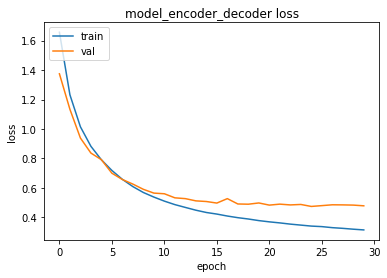

In [31]:
train_test(model_encoder_decoder, x_train, y_train , x_test, y_test, batch_size=batch_size,epochs=500, verbose=1)

In [32]:
# import os.path
# if os.path.isfile('models/LSTM_HIDS.h5') is False:
#     model_LSTM_return_sequences_return_state.save('models/LSTM_HIDS.h5')

In [33]:
# Receives one hot represetation and returns index where value = 1
def one_hot_decode(arr):
    for index,num in enumerate(arr):
        if num == 1:
            return index
        
# Receives an array to append to and a 3D-array that is one hot encoded      
def decode(arr, three_d_array):
    for seq in three_d_array:
        temp = []
        for one_hot in seq:
            temp.append(one_hot_decode(one_hot))
        arr.append(temp)
    
        

In [ ]:
# Decodes prediction done by LSTM and stores it in arr.
def prediction_decode(arr, prediction):
    for seq in prediction:
        predict_temp = []
        for one_hot in seq:
            predict_temp.append(argmax(one_hot))
        arr.append(predict_temp)
    
    

In [ ]:
# perfect match
from nltk.translate.bleu_score import sentence_bleu
def calc_belu(target, prediction):
    reference = []
    candidate = []
    reference.append(target)
    candidate.extend(prediction)
    return sentence_bleu(reference, candidate, weights=(0, 1))

In [ ]:
# VALIDATION

In [ ]:
print(train_validation_data[2])

In [ ]:
for i in range(len(train_validation_data)):
    for j in range(len(train_validation_data[i])):
        train_validation_data[i][j] = int(train_validation_data[i][j])

In [ ]:
print(len(train_validation_data))

In [ ]:
def calc_request_belu_score(request,start,end):
    request_sources = []
    request_targets = []
    request_prediction = []
    request_scores= []
    
    decoded_request_targets = []
    
    while(len(request)-start >= n+m):
        request_sources.append(generate_one_hot(request[start:end]))
        start += m
        end += m
        request_targets.append(request[start:end])
    
    i = 1
    while(i < len(request_sources)):
        prediction_decode( request_prediction, model_LSTM_return_sequences_return_state.predict(request_sources[i-1:i]))
        i += 1
    
    for i in range(len(request_prediction)):
        request_scores.append(calc_belu(request_targets[i],request_prediction[i]))
        
    print(request_scores)
    return request_scores

In [ ]:
means = []

for i in range(len(train_validation_data)-2300-1000):
    print(f'{i+1}/{len(train_validation_data)-2300-1000}')
    print('-------------------------------------------------------------------')
    means.append(statistics.mean(calc_request_belu_score(train_validation_data[i],0,n)))
    
    

In [ ]:
print(statistics.mean(means))
print(statistics.mean(attack_means))

In [ ]:
len(means)

#Binary Classification

In [ ]:
# threshold = 0.834

threshold = .85

false_negative = []
false_positive = []
normal = []
anomaly = []

for avg in means:
    if avg > threshold:
        normal.append(avg)
    else:
        false_negative.append(avg)

for avg in attack_means:
    if avg > threshold:
        false_positive.append(avg)
    else:
        anomaly.append(avg)

    
    


In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Safe','False_Negative'
sizes = [len(normal),len(false_negative)]
explode = (0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Attack', 'False_Positive'
sizes = [len(anomaly),len(false_positive)]
explode = (0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
#Binary End

In [ ]:
threshold = .91

weak_t = 0.78

medium_t = 0.65

percentages = []

def calculate_threat(avg_list):

    weak_count = 0
    medium_count = 0
    strong_count = 0
    green_light = 0

    for i in range(len(avg_list)):
        if avg_list[i] >= threshold:
            green_light += 1
        elif avg_list[i] >= weak_t:
            weak_count += 1
        elif avg_list[i] >= medium_t:
            medium_count += 1
        else:
            strong_count += 1
    

    
    print(f'Green Light: {green_light/len(avg_list)}')        
    print(f'Weak threat: {weak_count/len(avg_list)}')
    print(f'Medium threat: {medium_count/len(avg_list)}')
    print(f'Strong threat: {strong_count/len(avg_list)}')
    
    percentages.append(green_light/len(avg_list)* 100)
    percentages.append(weak_count/len(avg_list) * 100)
    percentages.append(medium_count/len(avg_list) * 100)
    percentages.append(strong_count/len(avg_list) * 100)

In [ ]:
calculate_threat(means)

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Safe', 'Weak Threat', 'Medium Threat', 'Strong Threat'
sizes = [percentages[0],percentages[1],percentages[2],percentages[3]]
explode = (0.2, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
percentages = []
calculate_threat(attack_means)

In [ ]:

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Safe', 'Weak Threat', 'Medium Threat', 'Strong Threat'
sizes = [percentages[0],percentages[1],percentages[2],percentages[3]]
explode = (0.6, 0, 0, 0.3)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
attack_means = []

for i in range((len(train_attack_data))):
    print(f'{i+1}/{len(train_attack_data)}')
    print('-------------------------------------------------------------------')
    attack_means.append(statistics.mean(calc_request_belu_score(train_attack_data[i],0,n)))
    
    
        
    

In [ ]:
plt.hist(means)
plt.hist(attack_means)